In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
filter_dir = './deploy/filter'
classification_dir = './deploy/classifier'

In [3]:
from data.dataset import AnnotatedData
from train import *
d = AnnotatedData.load('data/senna')

Couldn't import dot_parser, loading of dot files will not be possible.


In [18]:
import cPickle as pkl
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
import matplotlib
import matplotlib.pylab as P
import os
import json
from collections import Counter
import numpy as np
from pprint import pprint, pformat

def read_log(folder):
    with open(os.path.join(folder, 'train.log')) as f:
        logs = {}
        for l in f:
            d = json.loads(l.strip("\n"))
            for k, v in d.items():
                if k not in logs:
                    logs[k] = []
                logs[k] += [v]
    return logs

def read_args(folder):
    with open(os.path.join(folder, 'args.json')) as f:
        return json.load(f)

def read_test(folder):
    with open(os.path.join(folder, 'test.json')) as f:
        test = json.load(f)
    with open(os.path.join(folder, 'test.pkl')) as f:
        t = pkl.load(f)
    pred, targ = t['pred'].tolist(), t['targ'].tolist()
    
    counter = Counter(targ)
    order = np.array([e[0] for e in counter.most_common()])
    counts = np.array([e[1] for e in counter.most_common()])
    
    for rel, count in counter.most_common():
        print d.vocab['rel'].index2word[rel], count
    
    cm = confusion_matrix(targ, pred, order)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    labels = [r for r in d.vocab['rel'].index2word if r != 'no_relation' and counter[r] != 0]
    
    f1 = f1_score(targ, pred, average='micro', labels=labels)
    precision = precision_score(targ, pred, average='micro', labels=labels)
    recall = recall_score(targ, pred, average='micro', labels=labels)
    acc = accuracy_score(targ, pred)
    report = classification_report(targ, pred, target_names=d.vocab['rel'].index2word)
    return test, cm, counts, order, f1, precision, recall, acc, report

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


def plot_confusion_matrix(ax, cm, order, title='Confusion matrix', cmap=P.cm.Blues):
    names = [d.vocab['rel'].index2word[o] for o in order] if len(cm) > 2 else ['no_relation', 'relation']
    handle = ax.imshow(cm, interpolation='nearest', cmap=matplotlib.cm.Blues)
    ax.set_title(title)
    P.colorbar(handle, ax=ax)
    tick_marks = np.arange(len(names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(names, rotation=90)
    ax.set_yticklabels(names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
def plot_hist(ax, order, count, title='Histogram'):
    tick_marks = np.arange(len(order))
    ax.bar(tick_marks, count)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels([d.vocab['rel'].index2word[o] for o in order], rotation=90)
    ax.set_xlabel('relation')
    ax.set_ylabel('counts')
    
def print_experiment(e):
    args = read_args(e)
    logs = read_log(e)
    test, cm, counts, order, f1, precision, recall, acc, report = read_test(e)
    args.update(test)
    args.update({'f1': f1, 'precision': precision, 'recall': recall, 'acc':acc})
    
    fig, ax = P.subplots(3, figsize=(10, 30))
    
    desc = ax[0]
    hist = ax[2]
    acc = ax[1]
    
    desc.text(0.05, 0.95, pformat(args, indent=2), transform=desc.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    
    plot_hist(hist, order, counts)
    
    acc.plot(logs['train_f1'], label='train', color='b')
    acc.plot(logs['dev_f1'], label='dev', color='r')
    acc.set_ylabel('f1')
    acc.legend(loc='lower right')
    
    fig, conf = P.subplots(figsize=(10, 10))
    plot_confusion_matrix(conf, cm, order)

    print 'processed', e
    print report

per:employee_of 1040
no_relation 496
per:cities_of_residence 246
per:countries_of_residence 173
per:children 138
org:members 113
org:city_of_headquarters 97
per:title 91
org:stateorprovince_of_headquarters 80
org:parents 79
per:country_of_birth 77
per:stateorprovinces_of_residence 73
org:founded 70
org:subsidiaries 60
per:spouse 53
org:country_of_headquarters 49
per:city_of_birth 45
per:origin 40
per:alternate_names 39
org:top_members/employees 37
org:founded_by 26
org:dissolved 25
per:stateorprovince_of_death 21
per:schools_attended 21
org:alternate_names 20
org:member_of 19
per:parents 17
per:other_family 14
org:shareholders 10
per:stateorprovince_of_birth 9
per:city_of_death 9
per:date_of_birth 8
per:country_of_death 4
org:political/religious_affiliation 4
per:age 3
per:date_of_death 2
per:siblings 1
per:cause_of_death 1
processed ./deploy/classifier
                                     precision    recall  f1-score   support

                    per:employee_of       0.55      0.53

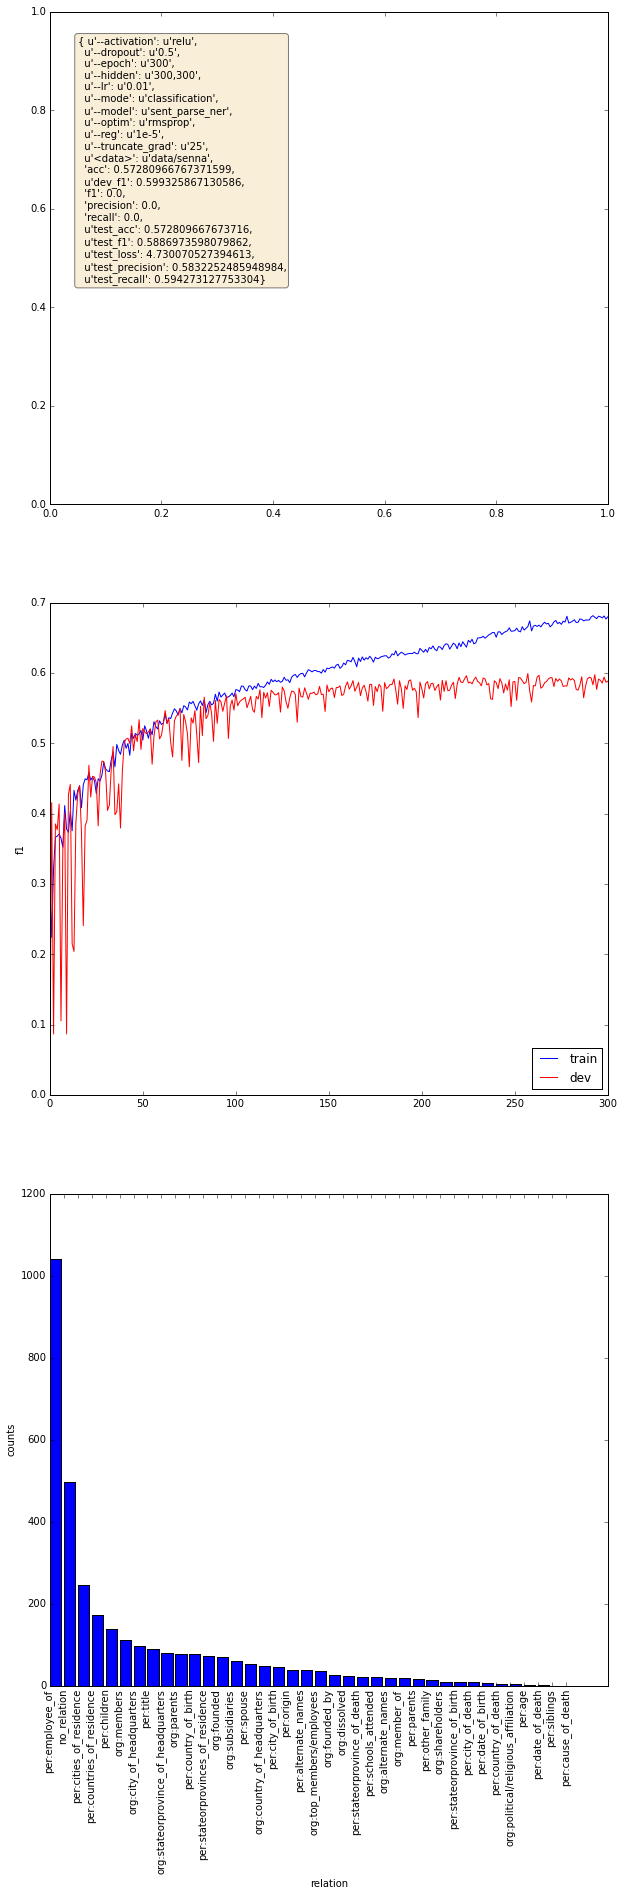

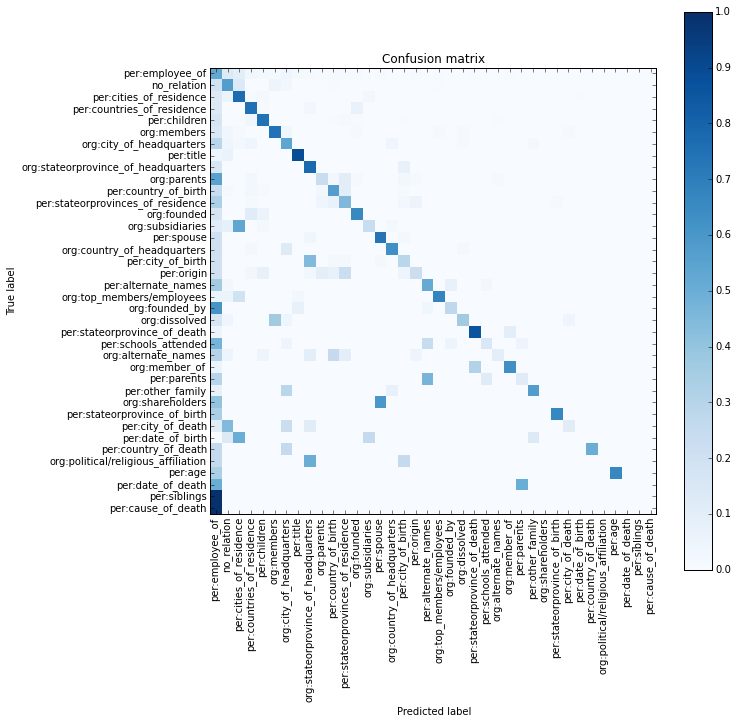

In [19]:
P.close('all')
print_experiment(classification_dir)